In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.model_selection import ParameterGrid
import time
import warnings
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.manifold import TSNE
from tensorflow.math import softplus
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras import Model
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.efficientnet import EfficientNetB0
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
# Sets the Ipython options

InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Design

# Sizes

title_size = 50
tick_size = 30
text_size = 30

In [4]:
# Functions 


def commit_result_in_ari_score_df(results):
    
    """Commits the specified results into ari_scores_df (initialized later on)"""
    
    for i in range(len(results)):     
        ari_scores_df.loc[len(ari_scores_df)] = results[i]

def compute_image_histogram(model, descriptors):
    
    """Computes the image's histogram according to a given model"""
    
    descriptors_clusters = model.predict(descriptors)
    
    histogram = np.zeros(len(model.cluster_centers_))
    
    for i in descriptors_clusters:
        histogram[i] += 1.0/len(descriptors_clusters)
        
    return histogram 

# Classes

class BOVWExtractor(BaseEstimator, TransformerMixin):
    
    """Vectorizes a given pd.Serie of images 
    with a given Bag of Visual Word technique"""
    
    def __init__(self, 
                 algorithm=None,
                 k_vectors=None):

        self.algorithm = algorithm
        self.k_vectors = k_vectors
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_ = X.copy()
        
        # Algorithm Init
        
        if self.algorithm == 'SIFT':
            algorithm = cv2.SIFT_create(500)
            
        elif self.algorithm == 'ORB':
            algorithm = cv2.ORB_create(500)
        else : 
            print('Please specify which algorithm (SIFT, ORB) you want to use')
            return None
        
        # Descriptors computation
        
        descriptors_list = []
        
        for loc, image_path in enumerate(X_):
    
            image_gray = cv2.imread(image_path, 0)
        
            image_gray_equalized = cv2.equalizeHist(image_gray)
    
            keypoints, descriptors = algorithm.detectAndCompute(image_gray_equalized, None)
    
            descriptors_list.append(descriptors)
        
        descriptors_by_image = np.asarray(descriptors_list, dtype='object')
        descriptors_all_images = np.concatenate(descriptors_list, axis=0)
        
        # Bag of Visual Words 
        
        if self.k_vectors is None:
            k_vectors = int(round(np.sqrt(len(descriptors_all_images)),0))
               
        else:
            k_vectors = self.k_vectors
        
        kmeans = MiniBatchKMeans(n_clusters=k_vectors, 
                                 init_size=3*k_vectors,
                                 batch_size= 2048,
                                 verbose=0,
                                 random_state=random_seed)\
                      .fit(descriptors_all_images)
        
        # Vectorizes the images
        
        histogram_vectors = []

        for loc, image_descriptors in enumerate(descriptors_by_image):
    
            histogram = compute_image_histogram(kmeans, 
                                                image_descriptors)
    
            histogram_vectors.append(histogram)
        
        images_features = np.asarray(histogram_vectors)

        return images_features

class CNNExtractor(BaseEstimator, TransformerMixin):
    
    """Vectorizes a given pd.Serie of images 
    with a given Convolutional neural network architecture"""
    
    def __init__(self, 
                 architecture=None,
                 pixel=None,
                 verbose=False):

        self.architecture = architecture
        self.pixel = pixel
        self.verbose = verbose
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_ = X.copy()
        
        # Checks for the presency of essential arguments
        
        if self.pixel is None:
            print('Please specify a pixel size')
            return None
        
        if self.architecture is None:
            print('Please specify an architecture')
            return None
        
        # Pixel Part
        
        images_resized_list = []

        for loc, image_path in enumerate(X_):
    
            image = cv2.imread(image_path)

            image_resized = cv2.resize(image, (self.pixel, self.pixel))
    
            images_resized_list.append(image_resized)


        images_resized_list = np.array(images_resized_list)
        
        # Inits an architecture
        
        if self.architecture == 'VGG16':
            
            architecture = VGG16(weights="imagenet", 
                                 include_top=False, 
                                 input_shape=(224, 224, 3))
            
        elif self.architecture == 'ResNet50V2':
            
            architecture = ResNet50V2(weights="imagenet", 
                                      include_top=False, 
                                      input_shape=(224, 224, 3))
            
        elif self.architecture == 'EfficientNetB0':
            
            architecture = EfficientNetB0(weights="imagenet", 
                                          include_top=False, 
                                          input_shape=(224, 224, 3))
            
        # Adds a flatten layer to the architecture
        
        output = Flatten()(architecture.layers[-1].output)
        
        model = Model(inputs=architecture.inputs, outputs=output)
        
        # Puts layers into a non trainable mode
        
        for layer in model.layers:
            layer.trainable = False
            
        # Displays the model architecture if verbose activated
        
        if self.verbose == True:
            model.summary()
            
        # Computes the feature matrix

        feature_matrix = model.predict(images_resized_list)
            
        return feature_matrix

In [5]:
# Inits a random seed

random_seed = 34

# Imports cleaned dataset

flipkart_df = \
    pd.read_csv(r'F:\Data\Projet 6\Cleaned\flipkart_cleaned')

<h6>Set ups

In [6]:
# Defines X and y

X = flipkart_df['image_path']
y = LabelEncoder().fit_transform(flipkart_df['product_category_node_2'])

In [7]:
# Inits a dataframe to commit results

ari_scores_df = pd.DataFrame(columns=['Feature_Extraction',
                                      'ARI',
                                      'Preprocessing_name',
                                      'Preprocessing_params',
                                      'Fit_score'])

In [8]:
# Inits a Tsne for visualization

tSNE_visualizer = TSNE(n_components=2,
                       learning_rate=300,
                       perplexity=30,
                       init='random',
                       random_state=random_seed)

<h6>Feature Extraction

In [9]:
# Bag of Visual Words Features Extractions

sift_feature_matrix = BOVWExtractor(algorithm='SIFT').fit_transform(X)

sift_feature_matrix.shape

orb_feature_matrix = BOVWExtractor(algorithm='ORB').fit_transform(X)

orb_feature_matrix.shape

(1050, 719)

(1050, 721)

In [10]:
# CNNs Features Extractions

vgg16_feature_matrix = CNNExtractor(architecture='VGG16', 
                                    pixel=224, 
                                    verbose=True).fit_transform(X)

vgg16_feature_matrix.shape

res_net_50_v2_feature_matrix = CNNExtractor(architecture='ResNet50V2', 
                                            pixel=224, 
                                            verbose=True).fit_transform(X)

res_net_50_v2_feature_matrix.shape

efficient_net_feature_matrix = CNNExtractor(architecture='EfficientNetB0', 
                                            pixel=224, 
                                            verbose=True).fit_transform(X)

efficient_net_feature_matrix.shape

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

(1050, 25088)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

(1050, 100352)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']    

 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3b_a

 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     
          

                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      
                                                                                                  
 block5a_s

 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     
                                                                                                  
 block5c_a

                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  10368       ['block7a_expand_activation[0][0]
 D)       

(1050, 62720)

In [11]:
# Defines a dictionary with matrix names and matrixes 

matrix_dict = {
    'SIFT': sift_feature_matrix,
    'ORB': orb_feature_matrix,
    'VGG16': vgg16_feature_matrix,
    'ResNet50V2': res_net_50_v2_feature_matrix,
    'EfficientNetB0': efficient_net_feature_matrix}

<center><h1>Unsupervised Modelling

<h6>No dimentionality reduction

In [12]:
# Inits a Kmeans

kmeans = KMeans(n_clusters=62, random_state=random_seed)

In [13]:
# Computes ARI on matrixes without dimentionality reduction

adjusted_rand_score(y, kmeans.fit_predict(sift_feature_matrix))

adjusted_rand_score(y, kmeans.fit_predict(orb_feature_matrix))

adjusted_rand_score(y, kmeans.fit_predict(vgg16_feature_matrix))

adjusted_rand_score(y, kmeans.fit_predict(res_net_50_v2_feature_matrix))

adjusted_rand_score(y, kmeans.fit_predict(efficient_net_feature_matrix))

0.04997956673335554

0.03418737257426706

0.13910321064474857

0.09230307974299977

0.1519470942854074

<h6>PCA

In [14]:
def pca_grid_search(matrix, grid, feature_extraction_name):
    
    """Computes and return results of a 7-Means with a 
    PCA dimentionality reduction according to a specified 
    grid of params on a given matrix"""
    
    results = []

    for i in list(grid):
    
        t0 = time.time()
        
        # Dimentionality reduction
        with warnings.catch_warnings():
        
            warnings.simplefilter(action='ignore', category=FutureWarning)
        
            X_pca = PCA(n_components=i['pca__n_components'])\
                            .fit_transform(matrix)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(X_pca)
    
        fit_time = time.time() - t0
        
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y, predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'PCA', i, fit_time))
        
    return results

In [15]:
# Defines a grid of params

pca_pipeline_params_grid = \
    ParameterGrid({'pca__n_components': [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]})

In [16]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = pca_grid_search(matrix, pca_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : SIFT
Computing : ORB
Computing : VGG16
Computing : ResNet50V2
Computing : EfficientNetB0
DONE


<h6>PCA + TSNE

In [17]:
def pca_tsne_grid_search(matrix, grid, feature_extraction_name, verbose=False):
    
    """Computes and return results of a 7-Means with a 
    PCA + TSNE dimentionality reduction according to a specified 
    grid of params on a given matrix"""

    results = []

    for i in list(grid):
        
        t0 = time.time()
        
        if verbose:
            print(i)

        # Dimentionality reduction
        with warnings.catch_warnings():
        
            warnings.simplefilter(action='ignore', category=FutureWarning)
            
            X_pca = PCA(n_components=i['pca__n_components'])\
                            .fit_transform(matrix)
    
            X_tSNE = TSNE(n_components=i['tsne__n_components'], 
                          perplexity=i['perplexity'], 
                          learning_rate=i['learning_rate'], 
                          init='random',
                          random_state=random_seed)\
                            .fit_transform(X_pca)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(X_tSNE)
        
        fit_time = time.time() - t0
    
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y, predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'PCA TSNE', i, fit_time))
    
    return results

In [18]:
# Defines a grid of params

pca_tsne_pipeline_params_grid = \
    ParameterGrid(
           [{'pca__n_components': [0.99,0.9,0.8,0.7,0.6,0.5,0.4],
             'tsne__n_components': [2,3], 
             'perplexity':[30,40],
             'learning_rate':[300],
             'method':['barnes_hut']}])

In [19]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = pca_tsne_grid_search(matrix, pca_tsne_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : SIFT
Computing : ORB
Computing : VGG16
Computing : ResNet50V2
Computing : EfficientNetB0
DONE


<h6>LDA

Notice for LDA Speedness

In [20]:
# Keeping the 99% of variance of each matrix 
# through PCA reduces significantly the dimsenstionality
# therefore reducing significantly the LDA dimentionality reduction 
# technique which can take hours otherwise


# Demonstrates the above notice 

print('SIFT :')
sift_feature_matrix.shape

example1 = PCA(n_components=0.99).fit_transform(sift_feature_matrix)

example1.shape

print('ORB :')
orb_feature_matrix.shape

example2 = PCA(n_components=0.99).fit_transform(orb_feature_matrix)

example2.shape

print('VGG16 :')
vgg16_feature_matrix.shape

example3 = PCA(n_components=0.99).fit_transform(vgg16_feature_matrix)

example3.shape

print('ResNet50V2 :')
res_net_50_v2_feature_matrix.shape

example4 = PCA(n_components=0.99).fit_transform(res_net_50_v2_feature_matrix)

example4.shape

print('EfficientNetB0 :')
efficient_net_feature_matrix.shape

example5 = PCA(n_components=0.99).fit_transform(efficient_net_feature_matrix)

example5.shape

SIFT :


(1050, 719)

(1050, 496)

ORB :


(1050, 721)

(1050, 577)

VGG16 :


(1050, 25088)

(1050, 940)

ResNet50V2 :


(1050, 100352)

(1050, 728)

EfficientNetB0 :


(1050, 62720)

(1050, 952)

In [21]:
def lda_grid_search(matrix, grid, feature_extraction_name, verbose=False):
    
    """Computes and return results of a 7-Means with a 
    LDA dimentionality reduction according to a specified 
    grid of params on a given matrix"""

    results = []

    for i in list(grid):
        
        if verbose:
            
            print(i)
            
        # Dimentionality reduction
        
        t0 = time.time()
        
        # Keeps 99% of variance for speedness 
        
        X_pca = PCA(n_components=0.99).fit_transform(matrix)
             
        matrix = softplus(X_pca) 
            
        X_lda = LatentDirichletAllocation(n_components=i['lda__n_components'], 
                                          random_state=random_seed).fit_transform(matrix)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(X_lda)
        
        fit_time = time.time() - t0
    
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y,predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'LDA', i, fit_time))
    
    return results

In [22]:
# Defines a grid of params

lda_pipeline_params_grid = \
    ParameterGrid(
           [{'lda__n_components': [7, 14, 21]}])

In [23]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = lda_grid_search(matrix, lda_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : SIFT
Computing : ORB
Computing : VGG16
Computing : ResNet50V2
Computing : EfficientNetB0
DONE


<h6>SVD

In [24]:
def svd_grid_search(matrix, grid, feature_extraction_name, verbose=False):
    
    """Computes and return results of a 7-Means with a 
    SVD dimentionality reduction according to a specified 
    grid of params on a given matrix"""

    results = []

    for i in list(grid):
        
        if verbose:
            print(i)

        # Dimentionality reduction
        
        t0 = time.time()
            
        svd = TruncatedSVD(n_components=i['svd__n_components'], 
                    random_state=random_seed).fit_transform(matrix)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(svd)
        
        fit_time = time.time() - t0
    
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y, predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'SVD', i, fit_time))
    
    return results

In [25]:
# Defines a grid of params

svd_pipeline_params_grid = \
    ParameterGrid(
           [{'svd__n_components': [7, 14, 21]}])

In [26]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = svd_grid_search(matrix, svd_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : SIFT
Computing : ORB
Computing : VGG16
Computing : ResNet50V2
Computing : EfficientNetB0
DONE


<h6>NMF

In [27]:
def nmf_grid_search(matrix, grid, feature_extraction_name, verbose=False):
    
    """Computes and return results of a 7-Means with a 
    NMF dimentionality reduction according to a specified 
    grid of params on a given matrix"""

    results = []

    for i in list(grid):
        
        if verbose:
            print(i)
            
        if feature_extraction_name not in ['count_vectorized_matrix', 'tf_idf_matrix']:
            
            matrix = softplus(matrix) 

        # Dimentionality reduction
        
        t0 = time.time()
        
        X_nmf = NMF(n_components=i['nmf__n_components'], 
                    random_state=random_seed,
                    max_iter=10000,
                    init='random').fit_transform(matrix)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(X_nmf)
        
        fit_time = time.time() - t0
    
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y, predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'NMF', i, fit_time))
    
    return results

In [28]:
# Defines a grid of params

nmf_pipeline_params_grid = \
    ParameterGrid(
           [{'nmf__n_components': [7, 14, 21]}])

In [29]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = nmf_grid_search(matrix, nmf_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : SIFT
Computing : ORB
Computing : VGG16
Computing : ResNet50V2
Computing : EfficientNetB0
DONE


<center><h3>Results

In [30]:
# Displays the best scores per Feature Extration Matrix

top_per_feature_extraction_df = \
    ari_scores_df.loc[
        ari_scores_df['ARI'].sort_values(ascending=False).index]\
    .drop_duplicates(subset=['Feature_Extraction'])

with pd.option_context('display.max_colwidth', None):    
    top_per_feature_extraction_df

,Feature_Extraction,ARI,Preprocessing_name,Preprocessing_params,Fit_score
188,EfficientNetB0,0.268149,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.4, 'perplexity': 40, 'tsne__n_components': 2}",9.621240
132,VGG16,0.252281,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.4, 'perplexity': 40, 'tsne__n_components': 2}",7.419530
138,ResNet50V2,0.111833,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.9, 'perplexity': 30, 'tsne__n_components': 2}",12.059593
1,SIFT,0.053547,PCA,{'pca__n_components': 0.9},0.754769
96,ORB,0.039360,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.6, 'perplexity': 40, 'tsne__n_components': 2}",6.328173


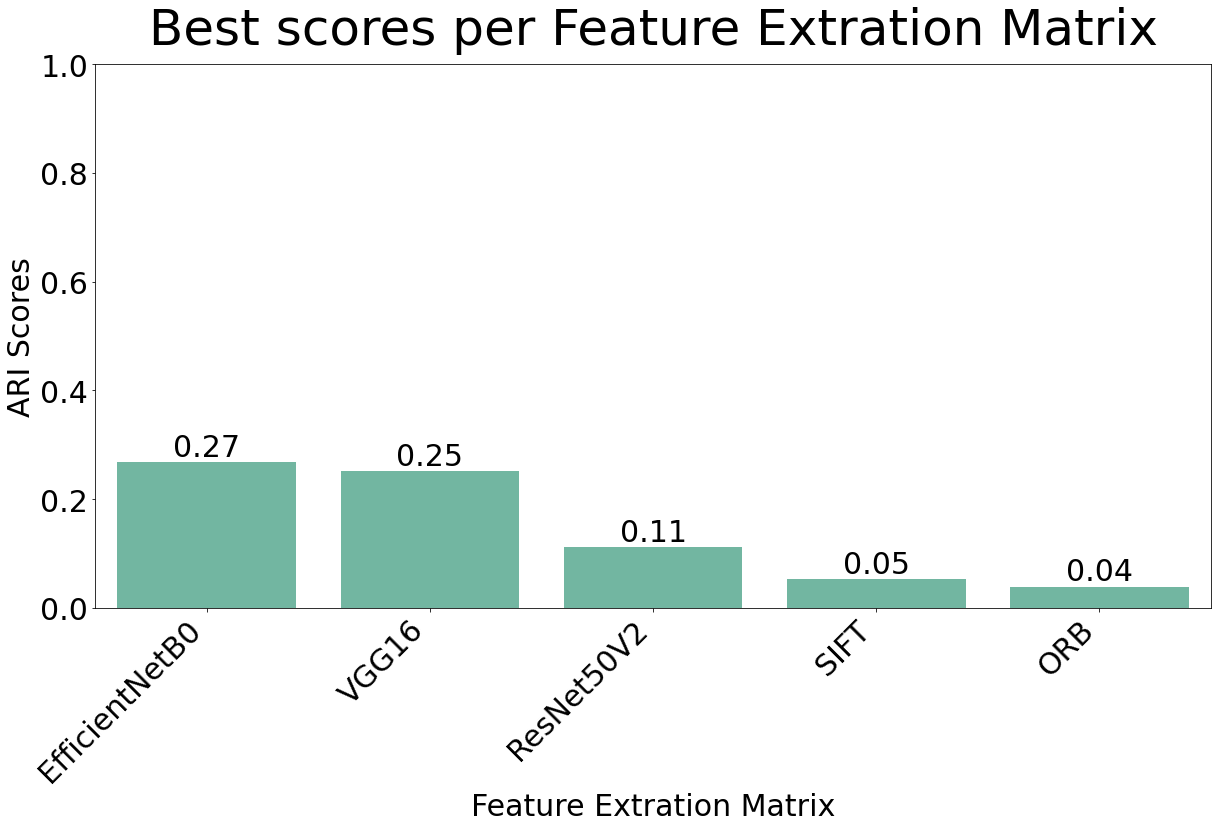

In [31]:
# Plots the best scores per Feature Extration Matrix

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=top_per_feature_extraction_df, 
            x='Feature_Extraction',
            y='ARI',
            palette = ['#66c2a5'],
            ax = ax)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', fontsize=text_size)
        
ax.set_ylim((0,1))
ax.set_ylabel('ARI Scores', fontsize=text_size)
ax.set_xlabel('Feature Extration Matrix', fontsize=text_size)

ax.tick_params(labelsize=tick_size)

plt.xticks(rotation=45, ha='right')

plt.title('Best scores per Feature Extration Matrix',
          fontsize=title_size,
          pad=20) 

plt.show();

In [32]:
# Displays the best scores per Dimentionality Reduction Technique

top_per_preprocessing_technique_df = \
    ari_scores_df.loc[
        ari_scores_df['ARI'].sort_values(ascending=False).index]\
    .drop_duplicates(subset=['Preprocessing_name'])

with pd.option_context('display.max_colwidth', None):    
    top_per_preprocessing_technique_df

,Feature_Extraction,ARI,Preprocessing_name,Preprocessing_params,Fit_score
188,EfficientNetB0,0.268149,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.4, 'perplexity': 40, 'tsne__n_components': 2}",9.621240
47,EfficientNetB0,0.243003,PCA,{'pca__n_components': 0.3},3.952482
219,EfficientNetB0,0.241511,SVD,{'svd__n_components': 21},1.362095
233,EfficientNetB0,0.218540,NMF,{'nmf__n_components': 14},109.632507
204,EfficientNetB0,0.168838,LDA,{'lda__n_components': 21},31.659821


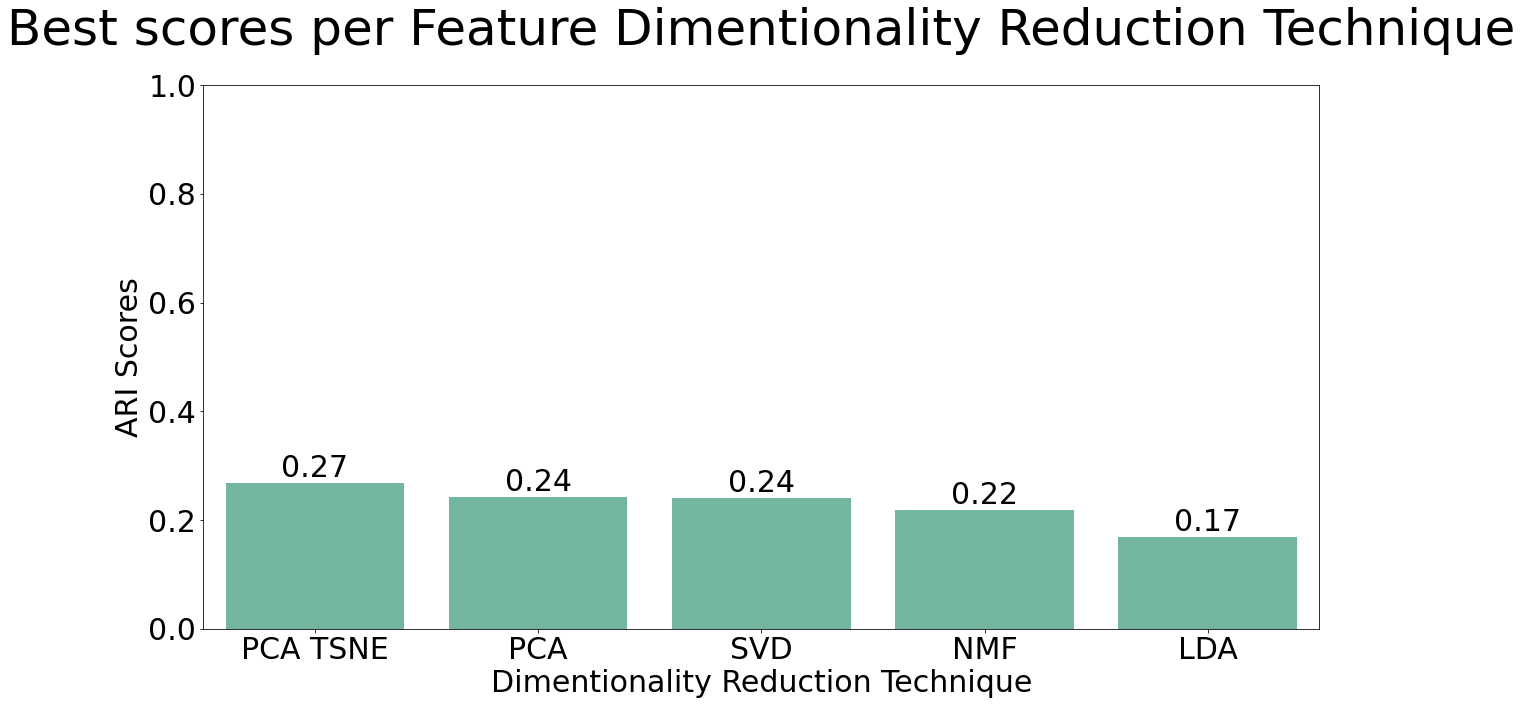

In [33]:
# Plots the best scores per Feature Extration Matrix

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=top_per_preprocessing_technique_df, 
            x='Preprocessing_name',
            y='ARI',
            palette = ['#66c2a5'],
            ax = ax)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', fontsize=text_size)
        
ax.set_ylim((0,1))
ax.set_ylabel('ARI Scores', fontsize=text_size)
ax.set_xlabel('Dimentionality Reduction Technique', fontsize=text_size)

ax.tick_params(labelsize=tick_size)

plt.title('Best scores per Feature Dimentionality Reduction Technique',
          fontsize=title_size,
          pad=40) 

plt.show();

<h6>Supervised

In [34]:
# Inits a dataframe to commit results of supervised trials

supervised_results_df = pd.DataFrame(columns=['Feature Extraction', 'Accuracy'])

BOVW

In [35]:
# Defines BOVW Pipeline

bovw_pipeline = Pipeline([
    ('bovw_extractor', BOVWExtractor(k_vectors=500)),
    ('random_forest_clf', RandomForestClassifier(max_depth=10, 
                                                 random_state=random_seed))
])

In [ ]:
# Grid searches bovw_pipeline

bovw_params = [{'bovw_extractor__algorithm' : ['SIFT', 'ORB']}]

bovw_gs = GridSearchCV(
                       bovw_pipeline, 
                       bovw_params, 
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True,
                       refit=True,
                       verbose=3)

bovw_gs.fit(X, y);

In [37]:
bovw_gs.cv_results_['mean_test_score']

array([0.13809524, 0.13809524])

In [38]:
# Commits the above computed results

supervised_results_df.loc[0, ['Feature Extraction', 'Accuracy']] = \
    'SIFT', bovw_gs.cv_results_['mean_test_score'][0]

supervised_results_df.loc[1, ['Feature Extraction', 'Accuracy']] = \
    'ORB', bovw_gs.cv_results_['mean_test_score'][1]

CNNs

In [39]:
# Defines CNN Pipeline

cnn_pipeline = Pipeline([
    ('cnn_extractor', CNNExtractor(pixel=224)),
    ('random_forest_clf', RandomForestClassifier(max_depth=10, 
                                                 random_state=random_seed))
])

In [ ]:
# Grid searches cnn_pipeline

cnn_params = [{'cnn_extractor__architecture' : ['VGG16', 'ResNet50V2','EfficientNetB0']}]

cnn_gs = GridSearchCV(
                       cnn_pipeline, 
                       cnn_params, 
                       cv=5, 
                       scoring='accuracy',
                       return_train_score=True,
                       refit=True,
                       verbose=3)

cnn_gs.fit(X, y);

In [41]:
cnn_gs.cv_results_['mean_test_score']

array([0.56761905, 0.43714286, 0.57333333])

In [42]:
# Commits the above computed results

supervised_results_df.loc[2, ['Feature Extraction', 'Accuracy']] = \
    'VGG16', cnn_gs.cv_results_['mean_test_score'][0]

supervised_results_df.loc[3, ['Feature Extraction', 'Accuracy']] = \
    'ResNet50V2', cnn_gs.cv_results_['mean_test_score'][1]

supervised_results_df.loc[4, ['Feature Extraction', 'Accuracy']] = \
    'EfficientNetB0', cnn_gs.cv_results_['mean_test_score'][2]

In [43]:
supervised_results_df

,Feature Extraction,Accuracy
0,SIFT,0.138095
1,ORB,0.138095
2,VGG16,0.567619
3,ResNet50V2,0.437143
4,EfficientNetB0,0.573333


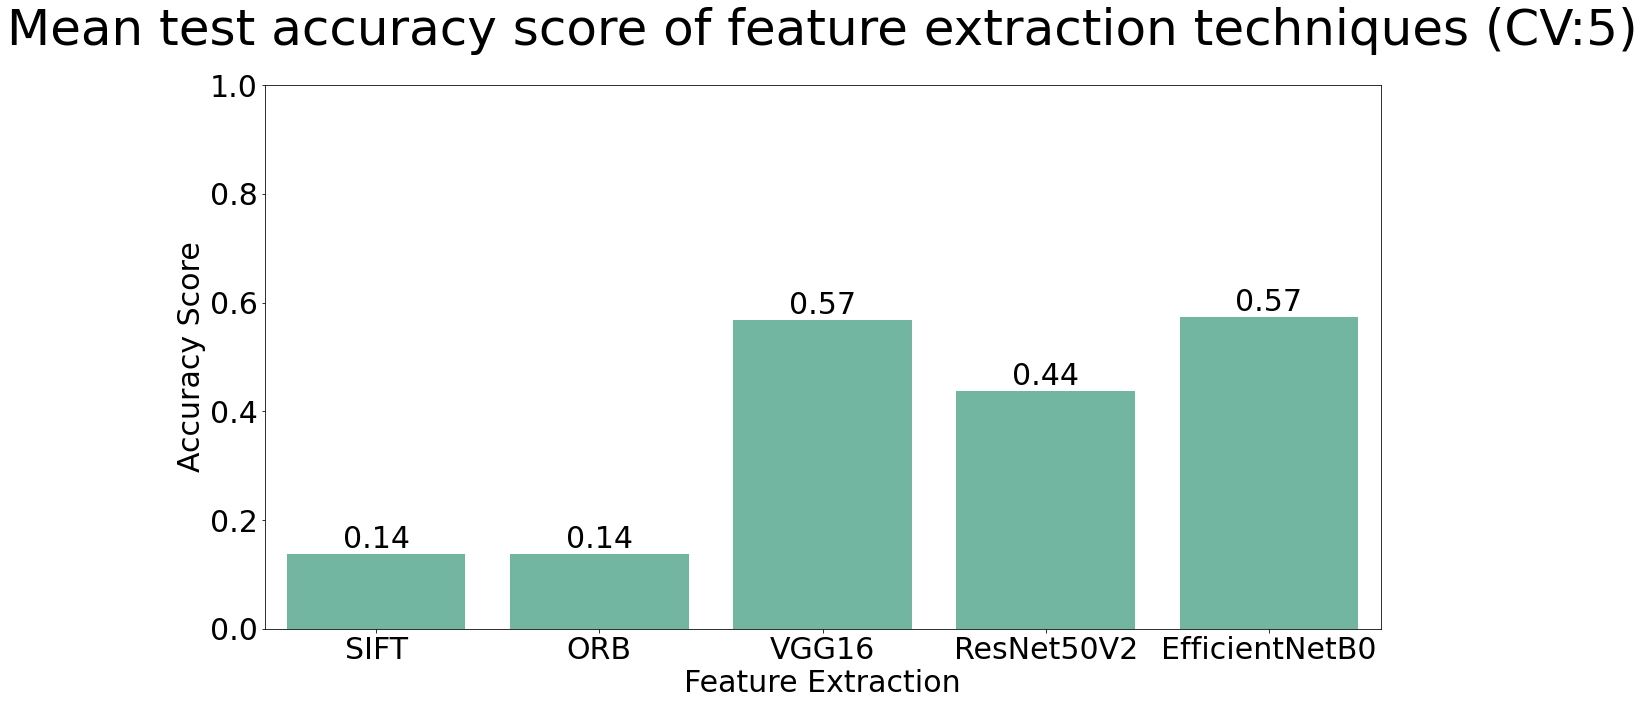

In [44]:
# Plots the best scores per Feature Extration Matrix

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=supervised_results_df, 
            x='Feature Extraction',
            y='Accuracy',
            palette = ['#66c2a5'],
            ax = ax)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', fontsize=text_size)
        
ax.set_ylim((0,1))
ax.set_ylabel('Accuracy Score', fontsize=text_size)
ax.set_xlabel('Feature Extraction', fontsize=text_size)

ax.tick_params(labelsize=tick_size)

plt.title('Mean test accuracy score of feature extraction techniques (CV:5)',
          fontsize=title_size,
          pad=40) 

plt.show();